# **Data Preprocessing**

In [1]:
! pip install -q kaggle

from google.colab import files

files.upload()


! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d alxmamaev/flowers-recognition

! unzip flowers-recognition.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/flowers/flowers/rose/110472418_87b6a3aa98_m.jpg  
  inflating: data/flowers/flowers/rose/11102341464_508d558dfc_n.jpg  
  inflating: data/flowers/flowers/rose/11233672494_d8bf0a3dbf_n.jpg  
  inflating: data/flowers/flowers/rose/11694025703_9a906fedc1_n.jpg  
  inflating: data/flowers/flowers/rose/118974357_0faa23cce9_n.jpg  
  inflating: data/flowers/flowers/rose/11944957684_2cc806276e.jpg  
  inflating: data/flowers/flowers/rose/12165480946_c4a3fe182d_n.jpg  
  inflating: data/flowers/flowers/rose/12202373204_34fb07205b.jpg  
  inflating: data/flowers/flowers/rose/12238827553_cf427bfd51_n.jpg  
  inflating: data/flowers/flowers/rose/12240165555_98625b1e88_n.jpg  
  inflating: data/flowers/flowers/rose/12240303_80d87f77a3_n.jpg  
  inflating: data/flowers/flowers/rose/12240577184_b0de0e53ea_n.jpg  
  inflating: data/flowers/flowers/rose/12243068283_ee4c2683e2_n.jpg  
  inflating: data/flowers/flowers/rose/12243069253

In [2]:
import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.image as mimg

from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras import layers
from keras import models
from keras import optimizers

In [3]:
# Check for the directory and if it doesn't exist, make one.
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
    
# make the models sub-directory
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [4]:
# original dataset folder, you can see above
input_path = Path('data/flowers/')
flowers_path = input_path / 'flowers'

In [5]:
# Each species of flower is contained in a separate folder. Get all the sub directories
flower_types = os.listdir(flowers_path)
print("Types of flowers found: ", len(flower_types))
print("Categories of flowers: ", flower_types)

Types of flowers found:  5
Categories of flowers:  ['rose', 'dandelion', 'daisy', 'tulip', 'sunflower']


In [6]:
# A list that is going to contain tuples: (species of the flower, corresponding image path)
flowers = []

for species in flower_types:
    # Get all the file names
    all_flowers = os.listdir(flowers_path / species)
    # Add them to the list
    for flower in all_flowers:
        flowers.append((species, str(flowers_path /species) + '/' + flower))

# Build a dataframe        
flowers = pd.DataFrame(data=flowers, columns=['category', 'image'], index=None)
flowers.head()

,category,image
0,rose,data/flowers/flowers/rose/5234278003_d827fcd73...
1,rose,data/flowers/flowers/rose/99383371_37a5ac12a3_...
2,rose,data/flowers/flowers/rose/16018886851_c32746cb...
3,rose,data/flowers/flowers/rose/5001845289_e5740889b...
4,rose,data/flowers/flowers/rose/110472418_87b6a3aa98...


In [7]:
# Let's check how many samples for each category are present
print("Total number of flowers in the dataset: ", len(flowers))
fl_count = flowers['category'].value_counts()
print("Flowers in each category: ")
print(fl_count)

Total number of flowers in the dataset:  4326
Flowers in each category: 
dandelion    1055
tulip         984
rose          784
daisy         769
sunflower     734
Name: category, dtype: int64


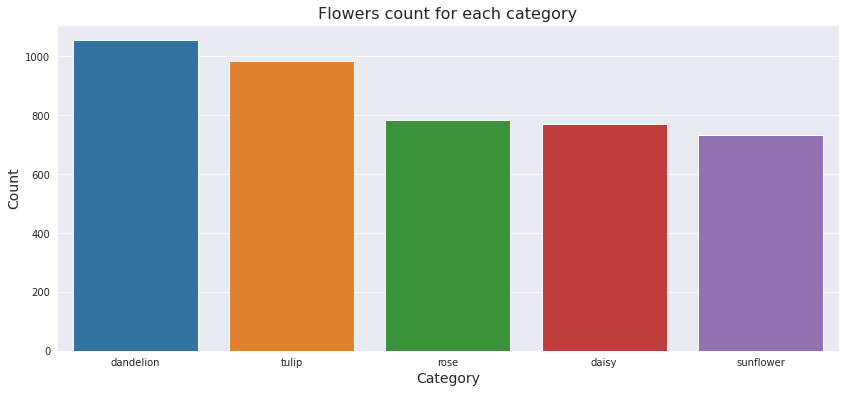

In [8]:
# Let's do some visualization and see how many samples we have for each category

f, axe = plt.subplots(1,1,figsize=(14,6))
sns.barplot(x = fl_count.index, y = fl_count.values, ax = axe)
axe.set_title("Flowers count for each category", fontsize=16)
axe.set_xlabel('Category', fontsize=14)
axe.set_ylabel('Count', fontsize=14)
plt.show()

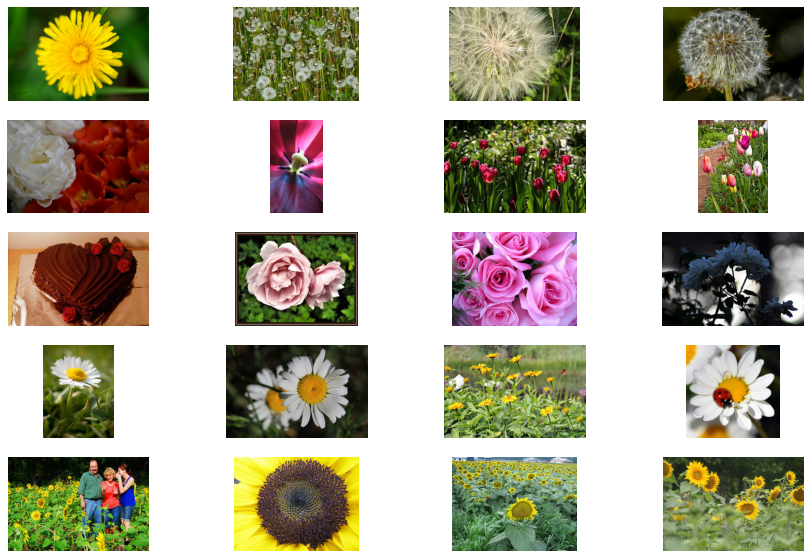

In [9]:
# Let's visualize some flowers from each category

# A list for storing names of some random samples from each category
random_samples = []

# Get samples fom each category 
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].sample(4).values
    for sample in samples:
        random_samples.append(sample)

# Plot the samples
f, ax = plt.subplots(5,4, figsize=(15,10))
for i,sample in enumerate(random_samples):
    ax[i//4, i%4].imshow(mimg.imread(random_samples[i]))
    ax[i//4, i%4].axis('off')
plt.show()  

In [10]:
# Make a parent directory `data` and two sub directories `train` and `valid`
%mkdir -p data/train
%mkdir -p data/valid

# Inside the train and validation sub=directories, make sub-directories for each catgeory
%cd data
%mkdir -p train/daisy
%mkdir -p train/tulip
%mkdir -p train/sunflower
%mkdir -p train/rose
%mkdir -p train/dandelion

%mkdir -p valid/daisy
%mkdir -p valid/tulip
%mkdir -p valid/sunflower
%mkdir -p valid/rose
%mkdir -p valid/dandelion

%cd ..

/content/data
/content


In [11]:
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].values
    perm = np.random.permutation(samples)
    # Copy first 100 samples to the validation directory and rest to the train directory
    for i in range(100):
        name = perm[i].split('/')[-1]
        shutil.copyfile(perm[i],'./data/valid/' + str(category) + '/'+ name)
    for i in range(101,len(perm)):
        name = perm[i].split('/')[-1]
        shutil.copyfile(perm[i],'./data/train/' + str(category) + '/' + name)

In [12]:
BATCH_SIZE = 16
IMAGE_SHAPE = (224, 224, 3)
IMAGE_TRAIN = 'data/train'
IMAGE_TEST = 'data/valid'

CLASS_NUM = 5
BATCH_SIZE = 16
EPOCH_STEPS = int(4323/BATCH_SIZE)
IMAGE_SHAPE = (224, 224, 3)

MODEL_NAME = 'googlenet_flower.h5'

epochs = 40

In [13]:
def my_generator(generator):
    while True: # keras requires all generators to be infinite
        data = next(generator)
        x = data[0]
        y = data[1], data[1], data[1]
        yield x, y

# prepare data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)


generator_main_train = train_datagen.flow_from_directory(
    IMAGE_TRAIN,
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

generator_main_test = train_datagen.flow_from_directory(
    IMAGE_TEST,
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    class_mode='categorical'
)

train_generator = my_generator(generator_main_train)
test_generator = generator_main_test

Found 3818 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


# **Save Best Weights**

In [14]:
import tensorflow as tf

checkpoint_filepath = 'drive/MyDrive/Checkpoint/GoogleNet-improvement-{epoch:02d}-{val_main_accuracy:.2f}.h5'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    verbose=1,
    monitor='val_main_accuracy',
    mode='max',
    save_best_only=True)

# **GoogleNet**

In [15]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

In [17]:
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 10 19:49:33 2019

@author: SCYLLA
"""

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
# print(os.listdir("../input/flowers/flowers"))

# define parameters

train_generator = my_generator(generator_main_train)
test_generator = generator_main_test


# create model
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer


def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model


# train model

#model.load_weights(MODEL_NAME)
#tf.keras.utils.plot_model(model, 'GoogLeNet.png')

#optimizer = Adam(lr=2 * 1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#optimizer = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

optimizer = ['Adam', 'SGD']

history_adam = {}
history_sgd = {}


for i in range(len(optimizer)):
    
    model = googlenet()
    model.summary()
    print('Usnig optimizer: ' + optimizer[i] + ', Epoch: ' + str(epochs))
    
    model.compile(loss='categorical_crossentropy', 
                  loss_weights={'main': 1.0, 'aux1': 0.3, 'aux2': 0.3},
                  optimizer=optimizer[i], metrics=['accuracy'])
    
    train_history = model.fit(
            generator_main_train,
            validation_data = test_generator,
            epochs=epochs,
            #callbacks=[checkpoint]
            shuffle=True,
            callbacks=[callback]
            )
    model.save(optimizer[i] + MODEL_NAME)
    
    if(i == 0):
      # save history    
      if len(history_adam) == 0:
          history_adam = {key: [] for key in train_history.history}
      
      for key in history_adam:
          history_adam[key].extend(train_history.history[key])
    else:

      if len(history_sgd) == 0:
          history_sgd = {key: [] for key in train_history.history}
      
      for key in history_sgd:
          history_sgd[key].extend(train_history.history[key])     

model.save(MODEL_NAME)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [18]:
# show train history
def show_train_history(history, xlabel, ylabel, train):
    for item in train:
        plt.plot(history[item])
    plt.title('Train History')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()

# show test history
def show_test_history(history, xlabel, ylabel, train):
    for item in train:
        plt.plot(history[item])
    plt.title('Test History')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()


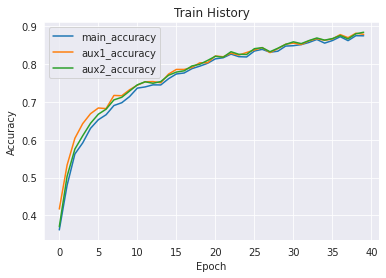

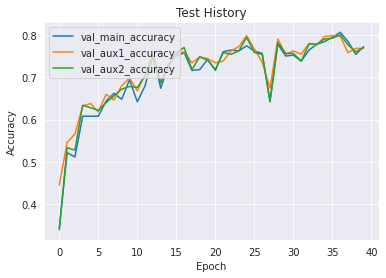

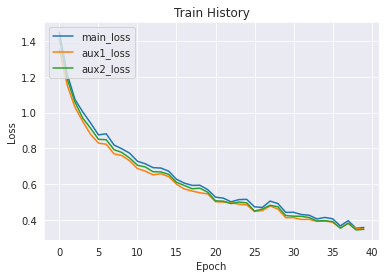

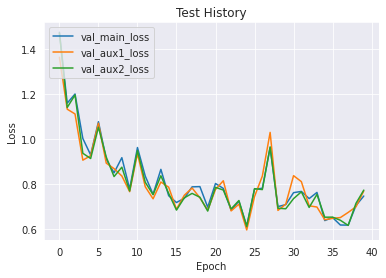

In [19]:

show_train_history(history_adam, 'Epoch', 'Accuracy', ('main_accuracy', 'aux1_accuracy', 'aux2_accuracy'))
show_test_history(history_adam, 'Epoch', 'Accuracy', ('val_main_accuracy', 'val_aux1_accuracy', 'val_aux2_accuracy'))
show_train_history(history_adam, 'Epoch', 'Loss', ('main_loss', 'aux1_loss', 'aux2_loss'))
show_test_history(history_adam, 'Epoch', 'Loss', ('val_main_loss', 'val_aux1_loss', 'val_aux2_loss'))

In [ ]:
# show train history
def show_acc_history(history, xlabel, ylabel, train):
    for item in train:
        plt.plot(history[item])
    plt.title('Accuracy History')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()

# show test history
def show_loss_history(history, xlabel, ylabel, train):
    for item in train:
        plt.plot(history[item])
    plt.title('Loss History')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()

# **LeNet**

In [ ]:
import tensorflow as tf

checkpoint_filepath = 'drive/MyDrive/Checkpoint/LeNet-improvement-{epoch:02d}-{val_accuracy:.2f}.h5'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    verbose=1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
modelLeNet = tf.keras.Sequential()

modelLeNet.add(layers.Conv2D(filters=6, input_shape=IMAGE_SHAPE, kernel_size=(3, 3), activation='relu'))
modelLeNet.add(layers.AveragePooling2D())

modelLeNet.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
modelLeNet.add(layers.AveragePooling2D())

modelLeNet.add(layers.Flatten())

modelLeNet.add(layers.Dense(units=120, activation='relu'))

modelLeNet.add(layers.Dense(units=84, activation='relu'))

modelLeNet.add(layers.Dense(units=5, activation = 'softmax'))

modelLeNet.build((None,224,224,3))

modelLeNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 222, 222, 6)       168       
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 111, 111, 6)       0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 109, 109, 16)      880       
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 54, 54, 16)        0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 46656)             0         
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 120)               5598840   
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, 84)                1

In [ ]:
modelLeNet.compile(loss='categorical_crossentropy', 
              optimizer='Adam', metrics=['accuracy'])

In [ ]:
train_history_LeNet = modelLeNet.fit(
        generator_main_train,
        validation_data = test_generator,
        epochs=epochs,
        #callbacks=[checkpoint]
        shuffle=True,
        callbacks=[callback]
        )

Epoch 1/40
239/239 [==============================] - 52s 214ms/step - loss: 1.4456 - accuracy: 0.3483 - val_loss: 1.4038 - val_accuracy: 0.3940

Epoch 00001: val_accuracy improved from -inf to 0.39400, saving model to drive/MyDrive/Checkpoint/LeNet-improvement-01-0.39.h5
Epoch 2/40
239/239 [==============================] - 51s 213ms/step - loss: 1.2382 - accuracy: 0.4790 - val_loss: 1.2729 - val_accuracy: 0.4320

Epoch 00002: val_accuracy improved from 0.39400 to 0.43200, saving model to drive/MyDrive/Checkpoint/LeNet-improvement-02-0.43.h5
Epoch 3/40
239/239 [==============================] - 51s 212ms/step - loss: 1.1610 - accuracy: 0.5291 - val_loss: 1.1879 - val_accuracy: 0.5000

Epoch 00003: val_accuracy improved from 0.43200 to 0.50000, saving model to drive/MyDrive/Checkpoint/LeNet-improvement-03-0.50.h5
Epoch 4/40
239/239 [==============================] - 50s 211ms/step - loss: 1.1290 - accuracy: 0.5382 - val_loss: 1.1501 - val_accuracy: 0.5500

Epoch 00004: val_accuracy imp

In [ ]:
history_all_LeNet = {}
# save history    
if len(history_all_LeNet) == 0:
    history_all_LeNet = {key: [] for key in train_history_LeNet.history}

for key in history_all_LeNet:
    history_all_LeNet[key].extend(train_history_LeNet.history[key])

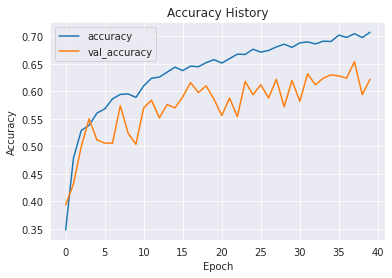

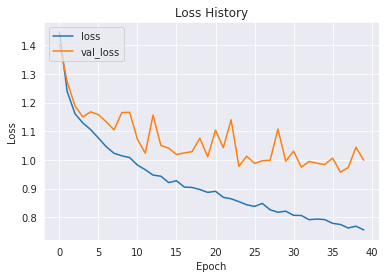

In [ ]:
show_acc_history(history_all_LeNet, 'Epoch', 'Accuracy', ('accuracy','val_accuracy'))
show_loss_history(history_all_LeNet, 'Epoch', 'Loss', ('loss','val_loss'))

In [ ]:
modelLeNet.save_weights('LeNet.h5')

# **AlexNet**

In [ ]:
import tensorflow as tf

checkpoint_filepath = 'drive/MyDrive/Checkpoint/AlexNet-improvement-{epoch:02d}-{val_accuracy:.2f}.h5'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    verbose=1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
modelAlexNet = tf.keras.Sequential()

modelAlexNet.add(layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)))
modelAlexNet.add(layers.BatchNormalization())
modelAlexNet.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
modelAlexNet.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
modelAlexNet.add(layers.BatchNormalization())
modelAlexNet.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
modelAlexNet.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
modelAlexNet.add(layers.BatchNormalization())
modelAlexNet.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
modelAlexNet.add(layers.BatchNormalization())
modelAlexNet.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
modelAlexNet.add(layers.BatchNormalization())
modelAlexNet.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
modelAlexNet.add(layers.Flatten())
modelAlexNet.add(layers.Dense(4096, activation='relu'))
modelAlexNet.add(layers.Dropout(0.5))
modelAlexNet.add(layers.Dense(4096, activation='relu'))
modelAlexNet.add(layers.Dropout(0.5))
modelAlexNet.add(layers.Dense(5, activation='softmax'))

modelAlexNet.build((None,224,224,3))

modelAlexNet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_8 (ModuleWrap (None, 54, 54, 96)        34944     
_________________________________________________________________
module_wrapper_9 (ModuleWrap (None, 54, 54, 96)        384       
_________________________________________________________________
module_wrapper_10 (ModuleWra (None, 26, 26, 96)        0         
_________________________________________________________________
module_wrapper_11 (ModuleWra (None, 26, 26, 256)       614656    
_________________________________________________________________
module_wrapper_12 (ModuleWra (None, 26, 26, 256)       1024      
_________________________________________________________________
module_wrapper_13 (ModuleWra (None, 12, 12, 256)       0         
_________________________________________________________________
module_wrapper_14 (ModuleWra (None, 12, 12, 384)      

In [ ]:
modelAlexNet.compile(loss='categorical_crossentropy', 
              optimizer='Adam', metrics=['accuracy'])

In [ ]:
train_history_AlexNet = modelAlexNet.fit(
        generator_main_train,
        validation_data = test_generator,
        epochs=epochs,
        #callbacks=[checkpoint]
        shuffle=True,
        callbacks=[callback]
        )

Epoch 1/40
239/239 [==============================] - 55s 224ms/step - loss: 2.6046 - accuracy: 0.3840 - val_loss: 1.5404 - val_accuracy: 0.3120

Epoch 00001: val_accuracy improved from -inf to 0.31200, saving model to drive/MyDrive/Checkpoint/AlexNet-improvement-01-0.31.h5
Epoch 2/40
239/239 [==============================] - 53s 222ms/step - loss: 1.4591 - accuracy: 0.4673 - val_loss: 1.2061 - val_accuracy: 0.4900

Epoch 00002: val_accuracy improved from 0.31200 to 0.49000, saving model to drive/MyDrive/Checkpoint/AlexNet-improvement-02-0.49.h5
Epoch 3/40
239/239 [==============================] - 53s 221ms/step - loss: 1.2403 - accuracy: 0.5199 - val_loss: 1.4355 - val_accuracy: 0.4560

Epoch 00003: val_accuracy did not improve from 0.49000
Epoch 4/40
239/239 [==============================] - 52s 219ms/step - loss: 1.1409 - accuracy: 0.5587 - val_loss: 1.0267 - val_accuracy: 0.5920

Epoch 00004: val_accuracy improved from 0.49000 to 0.59200, saving model to drive/MyDrive/Checkpoint

In [ ]:
history_all_AlexNet = {}
# save history    
if len(history_all_AlexNet) == 0:
    history_all_AlexNet = {key: [] for key in train_history_AlexNet.history}

for key in history_all_AlexNet:
    history_all_AlexNet[key].extend(train_history_AlexNet.history[key])

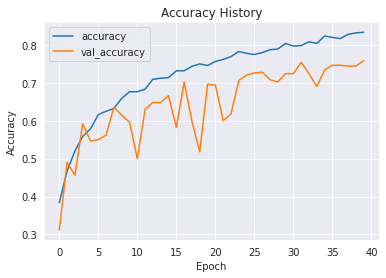

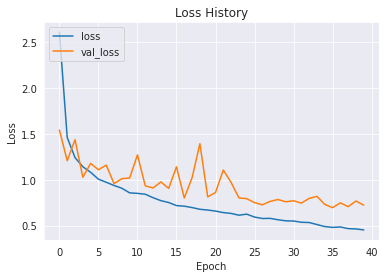

In [ ]:
show_acc_history(history_all_AlexNet, 'Epoch', 'Accuracy', ('accuracy','val_accuracy'))
show_loss_history(history_all_AlexNet, 'Epoch', 'Loss', ('loss','val_loss'))


In [ ]:
modelAlexNet.save_weights('AlexNet.h5')

# **ZFNet**

In [ ]:
modelZFNet = tf.keras.Sequential()

modelZFNet.add(layers.Conv2D(input_shape=(224,224,3), kernel_size=(7,7), filters=96, activation='relu',strides= [1,1],padding= 'valid'))# Convolution layer
modelZFNet.add(layers.MaxPool2D(pool_size=(3,3), strides=[2,2]))# Pooling layer
modelZFNet.add(layers.BatchNormalization(axis= 1))

modelZFNet.add(layers.Conv2D(kernel_size=(5,5), filters=256, activation='relu',strides= [2,2],padding= 'same'))# Convolution layer
modelZFNet.add(layers.MaxPool2D(pool_size=(3,3), strides=[1,1]))# Pooling layer
modelZFNet.add(layers.BatchNormalization(axis= 1))

modelZFNet.add(layers.Conv2D(kernel_size=(3,3), filters=384,activation='relu',strides= [1,1],padding= 'same'))# Convolution layer
modelZFNet.add(layers.BatchNormalization(axis= 1))

modelZFNet.add(layers.Conv2D(kernel_size=(3,3), filters=384, activation='relu',strides= [1,1],padding= 'same'))# Convolution layer
modelZFNet.add(layers.BatchNormalization(axis= 1))

modelZFNet.add(layers.Conv2D(kernel_size=(3,3), filters=256, activation='relu',strides= [1,1],padding= 'same'))# Convolution layer
modelZFNet.add(layers.MaxPool2D(pool_size=(3,3), strides=[1,1]))# Pooling layer
modelZFNet.add(layers.BatchNormalization(axis= 1))

modelZFNet.add(layers.Flatten())
modelZFNet.add(layers.Dense(4096, activation='relu'))
modelZFNet.add(layers.Dropout(0.5)) 
modelZFNet.add(layers.Dense(4096, activation='relu'))
modelZFNet.add(layers.Dropout(0.5)) 
modelZFNet.add(layers.Dense(5, activation='softmax'))


modelZFNet.build((None,224,224,3))

modelZFNet.summary()



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_104 (ModuleWr (None, 218, 218, 96)      14208     
_________________________________________________________________
module_wrapper_105 (ModuleWr (None, 108, 108, 96)      0         
_________________________________________________________________
module_wrapper_106 (ModuleWr (None, 108, 108, 96)      432       
_________________________________________________________________
module_wrapper_107 (ModuleWr (None, 54, 54, 256)       614656    
_________________________________________________________________
module_wrapper_108 (ModuleWr (None, 52, 52, 256)       0         
_________________________________________________________________
module_wrapper_109 (ModuleWr (None, 52, 52, 256)       208       
_________________________________________________________________
module_wrapper_110 (ModuleWr (None, 52, 52, 384)      

In [ ]:
modelZFNet.compile(loss='categorical_crossentropy', 
              optimizer='Adam', metrics=['accuracy'])

In [ ]:
history_all_ZFNet = {}
# save history    
if len(history_all_ZFNet) == 0:
    history_all_ZFNet = {key: [] for key in train_history_ZFNet.history}

for key in history_all_ZFNet:
    history_all_ZFNet[key].extend(train_history_ZFNet.history[key])

In [ ]:
show_acc_history(history_all_ZFNet, 'Epoch', 'Accuracy', ('accuracy','val_accuracy'))
show_loss_history(history_all_ZFNet, 'Epoch', 'Loss', ('loss','val_loss'))

In [ ]:
modelZFNet.save_weights('ZFNet.h5')

# **ZFNet(Changed)**

In [ ]:
import tensorflow as tf

checkpoint_filepath = 'drive/MyDrive/Checkpoint/ZFNet-improvement-{epoch:02d}-{val_accuracy:.2f}.h5'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    verbose=1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
modelZFNet = tf.keras.Sequential()

modelZFNet.add(layers.Conv2D(input_shape=(224,224,3), kernel_size=(7,7), filters=96, activation='relu',strides= [1,1],padding= 'valid'))# Convolution layer
modelZFNet.add(layers.MaxPool2D(pool_size=(3,3), strides=[2,2]))# Pooling layer
modelZFNet.add(layers.BatchNormalization(axis= 1))

modelZFNet.add(layers.Conv2D(kernel_size=(5,5), filters=256, activation='relu',strides= [2,2],padding= 'same'))# Convolution layer
modelZFNet.add(layers.MaxPool2D(pool_size=(3,3), strides=[1,1]))# Pooling layer
modelZFNet.add(layers.BatchNormalization(axis= 1))

modelZFNet.add(layers.Conv2D(kernel_size=(3,3), filters=384,activation='relu',strides= [1,1],padding= 'same'))# Convolution layer
modelZFNet.add(layers.BatchNormalization(axis= 1))

modelZFNet.add(layers.Conv2D(kernel_size=(3,3), filters=384, activation='relu',strides= [1,1],padding= 'same'))# Convolution layer
modelZFNet.add(layers.BatchNormalization(axis= 1))

modelZFNet.add(layers.Conv2D(kernel_size=(3,3), filters=32, activation='relu',strides= [1,1],padding= 'same'))# Convolution layer
modelZFNet.add(layers.MaxPool2D(pool_size=(3,3), strides=[1,1]))# Pooling layer
modelZFNet.add(layers.BatchNormalization(axis= 1))

modelZFNet.add(layers.Flatten())
modelZFNet.add(layers.Dense(64, activation='relu'))
modelZFNet.add(layers.Dropout(0.5)) 
modelZFNet.add(layers.Dense(4096, activation='relu'))
modelZFNet.add(layers.Dropout(0.5)) 
modelZFNet.add(layers.Dense(5, activation='softmax'))


modelZFNet.build((None,224,224,3))

modelZFNet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_27 (ModuleWra (None, 218, 218, 96)      14208     
_________________________________________________________________
module_wrapper_28 (ModuleWra (None, 108, 108, 96)      0         
_________________________________________________________________
module_wrapper_29 (ModuleWra (None, 108, 108, 96)      432       
_________________________________________________________________
module_wrapper_30 (ModuleWra (None, 54, 54, 256)       614656    
_________________________________________________________________
module_wrapper_31 (ModuleWra (None, 52, 52, 256)       0         
_________________________________________________________________
module_wrapper_32 (ModuleWra (None, 52, 52, 256)       208       
_________________________________________________________________
module_wrapper_33 (ModuleWra (None, 52, 52, 384)      

In [ ]:
modelZFNet.compile(loss='categorical_crossentropy', 
              optimizer='Adam', metrics=['accuracy'])

In [ ]:
train_history_ZFNet = modelZFNet.fit(
        generator_main_train,
        validation_data = test_generator,
        epochs=epochs,
        #callbacks=[checkpoint]
        shuffle=True,
        callbacks=[callback]
        )

Epoch 1/40
239/239 [==============================] - 80s 316ms/step - loss: 1.6114 - accuracy: 0.2766 - val_loss: 2.4199 - val_accuracy: 0.2000

Epoch 00001: val_accuracy improved from -inf to 0.20000, saving model to drive/MyDrive/Checkpoint/ZFNet-improvement-01-0.20.h5
Epoch 2/40
239/239 [==============================] - 66s 276ms/step - loss: 1.5189 - accuracy: 0.3669 - val_loss: 1.8808 - val_accuracy: 0.2700

Epoch 00002: val_accuracy improved from 0.20000 to 0.27000, saving model to drive/MyDrive/Checkpoint/ZFNet-improvement-02-0.27.h5
Epoch 3/40
239/239 [==============================] - 66s 276ms/step - loss: 1.4748 - accuracy: 0.3981 - val_loss: 1.5670 - val_accuracy: 0.2700

Epoch 00003: val_accuracy did not improve from 0.27000
Epoch 4/40
239/239 [==============================] - 66s 276ms/step - loss: 1.4331 - accuracy: 0.4089 - val_loss: 1.3849 - val_accuracy: 0.4040

Epoch 00004: val_accuracy improved from 0.27000 to 0.40400, saving model to drive/MyDrive/Checkpoint/ZFN

In [ ]:
history_all_ZFNet = {}
# save history    
if len(history_all_ZFNet) == 0:
    history_all_ZFNet = {key: [] for key in train_history_ZFNet.history}

for key in history_all_ZFNet:
    history_all_ZFNet[key].extend(train_history_ZFNet.history[key])

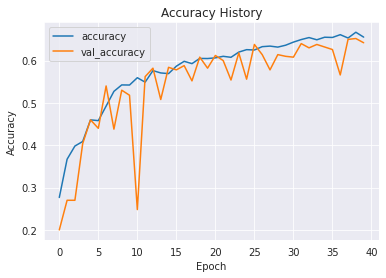

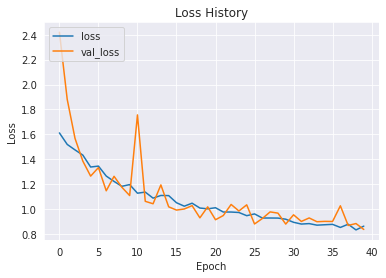

In [ ]:
show_acc_history(history_all_ZFNet, 'Epoch', 'Accuracy', ('accuracy','val_accuracy'))
show_loss_history(history_all_ZFNet, 'Epoch', 'Loss', ('loss','val_loss'))

In [ ]:
modelZFNet.save_weights('ZFNet.h5')

# **VGG-16**

In [ ]:
import tensorflow as tf

checkpoint_filepath = 'drive/MyDrive/Checkpoint/VGG-improvement-{epoch:02d}-{val_accuracy:.2f}.h5'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    verbose=1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
modelVGG = tf.keras.Sequential()

modelVGG.add(layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
modelVGG.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
modelVGG.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
modelVGG.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
modelVGG.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
modelVGG.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
modelVGG.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
modelVGG.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
modelVGG.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
modelVGG.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
modelVGG.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
modelVGG.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
modelVGG.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
modelVGG.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
modelVGG.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
modelVGG.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
modelVGG.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
modelVGG.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))

modelVGG.add(layers.Flatten())
modelVGG.add(layers.Dense(units=4096,activation="relu"))
modelVGG.add(layers.Dense(units=4096,activation="relu"))
modelVGG.add(layers.Dense(units=5, activation="softmax"))

modelVGG.build((None,224,224,3))

modelVGG.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_46 (ModuleWra (None, 224, 224, 64)      1792      
_________________________________________________________________
module_wrapper_47 (ModuleWra (None, 224, 224, 64)      36928     
_________________________________________________________________
module_wrapper_48 (ModuleWra (None, 112, 112, 64)      0         
_________________________________________________________________
module_wrapper_49 (ModuleWra (None, 112, 112, 128)     73856     
_________________________________________________________________
module_wrapper_50 (ModuleWra (None, 112, 112, 128)     147584    
_________________________________________________________________
module_wrapper_51 (ModuleWra (None, 56, 56, 128)       0         
_________________________________________________________________
module_wrapper_52 (ModuleWra (None, 56, 56, 256)      

In [ ]:
modelVGG.compile(loss='categorical_crossentropy', 
              optimizer='Adam', metrics=['accuracy'])

In [ ]:
train_history_VGG = modelVGG.fit(
        generator_main_train,
        validation_data = test_generator,
        epochs=epochs,
        #callbacks=[checkpoint]
        shuffle=True,
        callbacks=[callback]
        )

Epoch 1/40
239/239 [==============================] - 91s 356ms/step - loss: 1.6005 - accuracy: 0.2462 - val_loss: 1.6177 - val_accuracy: 0.2000

Epoch 00001: val_accuracy improved from -inf to 0.20000, saving model to drive/MyDrive/Checkpoint/VGG-improvement-01-0.20.h5
Epoch 2/40
239/239 [==============================] - 72s 301ms/step - loss: 1.5949 - accuracy: 0.2491 - val_loss: 1.6175 - val_accuracy: 0.2000

Epoch 00002: val_accuracy did not improve from 0.20000
Epoch 3/40
239/239 [==============================] - 71s 297ms/step - loss: 1.5844 - accuracy: 0.2575 - val_loss: 1.5827 - val_accuracy: 0.2420

Epoch 00003: val_accuracy improved from 0.20000 to 0.24200, saving model to drive/MyDrive/Checkpoint/VGG-improvement-03-0.24.h5
Epoch 4/40
239/239 [==============================] - 72s 301ms/step - loss: 1.5050 - accuracy: 0.2973 - val_loss: 1.4814 - val_accuracy: 0.3100

Epoch 00004: val_accuracy improved from 0.24200 to 0.31000, saving model to drive/MyDrive/Checkpoint/VGG-imp

In [ ]:
history_all_VGG = {}
# save history    
if len(history_all_VGG) == 0:
    history_all_VGG = {key: [] for key in train_history_VGG.history}

for key in history_all_VGG:
    history_all_VGG[key].extend(train_history_VGG.history[key])

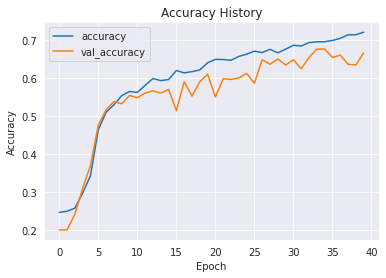

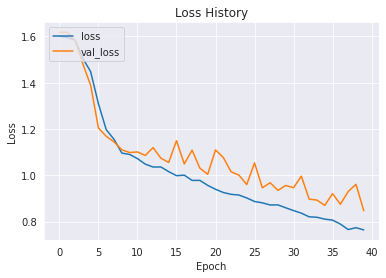

In [ ]:
show_acc_history(history_all_VGG, 'Epoch', 'Accuracy', ('accuracy','val_accuracy'))
show_loss_history(history_all_VGG, 'Epoch', 'Loss', ('loss','val_loss'))

In [ ]:
modelVGG.save_weights('VGG2.h5')

# **Comparison**

In [ ]:
import sklearn.metrics as metrics

**Confusion Matrix**

GoogleNet

In [ ]:
y_pred = model.predict(test_generator)

In [ ]:
y_true = test_generator.classes

In [ ]:
matrix = metrics.confusion_matrix(y_true, y_pred[0].argmax(axis=1))

In [ ]:
print(matrix)

[[32 12 14 21 21]
 [14 29 16 21 20]
 [14 28 33 14 11]
 [20 18 16 26 20]
 [13 13 25 25 24]]


LeNet

In [ ]:
y_pred = modelLeNet.predict(test_generator)

In [ ]:
y_true = test_generator.classes

In [ ]:
matrix = metrics.confusion_matrix(y_true, y_pred.argmax(axis=1))

In [ ]:
print(matrix)

[[16 33 18 15 18]
 [ 8 31 16 18 27]
 [16 30 15 16 23]
 [10 26 13 25 26]
 [ 7 34 21 18 20]]


AlexNet

In [ ]:
y_pred = modelAlexNet.predict(test_generator)

In [ ]:
y_true = test_generator.classes

In [ ]:
matrix = metrics.confusion_matrix(y_true, y_pred.argmax(axis=1))

In [ ]:
print(matrix)

[[19 16 11 13 41]
 [18 20 19 20 23]
 [20 19 20 19 22]
 [19 22 15 16 28]
 [22 24 16 19 19]]


ZFNet

In [ ]:
y_pred = modelZFNet.predict(test_generator)

In [ ]:
y_true = test_generator.classes

In [ ]:
matrix = metrics.confusion_matrix(y_true, y_pred.argmax(axis=1))

In [ ]:
print(matrix)

[[19 23  6 25 27]
 [17 21  5 23 34]
 [22 20  1 19 38]
 [15 24 11 24 26]
 [19 18  8 19 36]]


VGG

In [ ]:
y_pred = modelVGG.predict(test_generator)

In [ ]:
y_true = test_generator.classes

In [ ]:
matrix = metrics.confusion_matrix(y_true, y_pred.argmax(axis=1))

In [ ]:
print(matrix)

[[17 32 18 20 13]
 [15 22 17 24 22]
 [20 29 19 22 10]
 [18 30 20 16 16]
 [18 23 22 17 20]]


**Top-3 Accuracy**

In [ ]:
def top3Acc(model,x,labels):

  top3 = 0.0    
  class_probs = model.predict(x)
  for i, l in enumerate(labels):
      class_prob = class_probs[i]
  
      top_values = (-class_prob).argsort()[:3]
   

      if np.isin(np.array([l]), top_values):
          top3 += 1.0


  return (top3/len(labels))

In [ ]:
def top3AccGoogleNet(model,x,labels):

  top3 = 0.0    
  class_probs = model.predict(x)
  for i, l in enumerate(labels):
      class_prob = class_probs[0][i]
  
      top_values = (-class_prob).argsort()[:3]
   

      if np.isin(np.array([l]), top_values):
          top3 += 1.0

  return (top3/len(labels))

GoogleNet

In [ ]:
y_true = test_generator.classes
top3GoogleNet = top3AccGoogleNet(model,test_generator,y_true)
print(top3GoogleNet)

0.796


LeNet

In [ ]:
y_true = test_generator.classes
top3LeNet = top3Acc(modelLeNet,test_generator,y_true)
print(top3LeNet)

0.606


AlexNet

In [ ]:
y_true = test_generator.classes
top3AlexNet = top3Acc(modelAlexNet,test_generator,y_true)
print(top3AlexNet)

0.616


ZFNet

In [ ]:
y_true = test_generator.classes
top3ZFNet = top3Acc(modelZFNet,test_generator,y_true)
print(top3ZFNet)

0.622


VGG

In [ ]:
y_true = test_generator.classes
top3VGG = top3Acc(modelVGG,test_generator,y_true)
print(top3VGG)

0.62


# **Load Models**

In [ ]:
model.load_weights('drive/MyDrive/Pattern/GoogleNet.h5')

In [ ]:
modelLeNet.load_weights('drive/MyDrive/Pattern/LeNet.h5')

In [ ]:
modelAlexNet.load_weights('drive/MyDrive/Pattern/AlexNet.h5')

In [ ]:
modelZFNet.load_weights('drive/MyDrive/Pattern/ZFNet.h5')

In [ ]:
modelVGG.load_weights('drive/MyDrive/Pattern/VGG2.h5')

In [ ]:
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer
def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model
model = googlenet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 56, 56, 64)   0           conv2d_62[0][0]                  
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 56, 56, 64)   256         max_pooling2d_15[0][0]           
____________________________________________________________________________________________